# Combinación de ambos modelos

En este notebook vamos a recrear el proceso completo con los dos modelos que hemos entrenado, desde cargar una imagen inicial hasta la obtención del archivo MIDI final.

## Cargamos los modelos

In [ ]:
from models.extender_midi.model import MelodIAModel, Utilities
from models.foto_a_midi.main import FotoAMIDI
import joblib

# Cargamos los modelos
MODEL_PARAMS_PATH = "models/pretrained_models/modelo_params_midi.h5"
SCALER_PATH = "models/foto_a_midi/scaler.pkl"
MODEL_MIDI_EXTENSION_PATH = "models/pretrained_models/modelo_extension_midi.keras"

modelo_params = FotoAMIDI(modelo_ruta=MODEL_PARAMS_PATH, usar_clip=True)
modelo_params.load_modelo()
modelo_params.set_scaler(joblib.load(SCALER_PATH))

modelo_extender_midi = MelodIAModel.load_model(MODEL_MIDI_EXTENSION_PATH)

## Modelo 1: Foto a MIDI

In [2]:
import os
from PIL import Image
from models.foto_a_midi.midi_generator.midi_generator_acordes import ParamsAMIDI

# Cargamos la imagen
IMAGE_PATH = "models/foto_a_midi/datos/test/snow.jpg"
im = Image.open(IMAGE_PATH)

Metemos la imagen en el modelo y predecimos sus parametros

In [3]:
params = modelo_params.predict(im)

I0000 00:00:1747594402.625889  169843 service.cc:152] XLA service 0x7f5c9c0d1450 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1747594402.625958  169843 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce RTX 2050, Compute Capability 8.6
2025-05-18 20:53:22.642712: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1747594402.678007  169843 cuda_dnn.cc:529] Loaded cuDNN version 90501


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 546ms/step


I0000 00:00:1747594403.011761  169843 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


Podemos ver los parámetros generados

In [4]:
params

{'tonalidad_value': np.float64(0.32952771043277596),
 'tempo': np.float64(97.0),
 'duracion_media': np.float64(1.5296958777117486),
 'sigma': np.float64(0.5604123005417309),
 'velocidad_media': np.float64(0.8507442270569159),
 'densidad_media': np.float64(0.6509456750583507),
 'caracter_melodico': np.float64(0.7139184855786882),
 'usar_acordes': np.float64(1.0),
 'proporcion_acordes': np.float64(0.4605018856999854),
 'rango_octavas': np.float64(1.0)}

In [6]:
from models.foto_a_midi.modelo import clip_parametros

# Convertimos los parámetros a los tipos correctos
keys = params.keys()
values = clip_parametros(list(params.values()))
params2 = dict(zip(keys, values))

Generamos un archivo MIDI a partir de los parámetros devueltos por el modelo

In [7]:
MIDI_PATH = "prueba_nieve.mid"

# Generamos el midi a partir de los parámetros obtenidos
midi_basico = ParamsAMIDI(**params2)
midi_basico.generar_midi(MIDI_PATH)

# Si el midi tiene menos de 25 notas, lo concatenamos
import pretty_midi

pm = pretty_midi.PrettyMIDI(MIDI_PATH)

Archivo MIDI generado: prueba_nieve.mid


Como el segundo modelo utiliiza secuencias de 25 notas, comprobamos si el MIDI generado tiene al menos 25 notas. Si no, añadimos más notas.

In [8]:
num_notas = len(pm.instruments[0].notes)

if (num_notas < 25):
    n = 25 / num_notas + 1
    aux = pm
    for i in range(0, n):
        aux = Utilities.concatenate_pretty_midi(pm, aux)
    pm = aux

Lo escuchamos

In [12]:
Utilities.display_audio(pm)

## Modelo 2: Extensión del archivo MIDI generado

Seleccionamos las últimas 25 notas del MIDI generado anteriormente. Esta secuencia de notas será el input de este segundo modelo.

In [9]:
import pretty_midi

df = Utilities.midi_path_to_df(MIDI_PATH)
notes = Utilities.midi_to_numpy(pm)
notes_sequence = notes[num_notas-25:num_notas] # últimas 25 notas
notes = MelodIAModel.normalize(notes_sequence) 

Generamos las nuevas notas con el modelo. Haremos una predicción por cada nota que queramos generar (en este caso 40). Para la predicción de la siguiente nota se añade a la secuencia de 25 notas la última nota predicha como última nota de la secuencia.

In [11]:
# Se pueden cambiar el número de predicciones y la temperatura
generated_notes = MelodIAModel.predict_sequence(modelo_extender_midi, notes, num_predictions=30, temperature=0.8)

generated_notes = MelodIAModel.desnormalize(generated_notes)
generado = Utilities.notes_to_midi(generated_notes)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step
1/1 ━━━━━━

Unimos el fragmento MIDI original con el generado

In [13]:
combined = Utilities.concatenate_pretty_midi(pm, generado)

Lo visualizamos

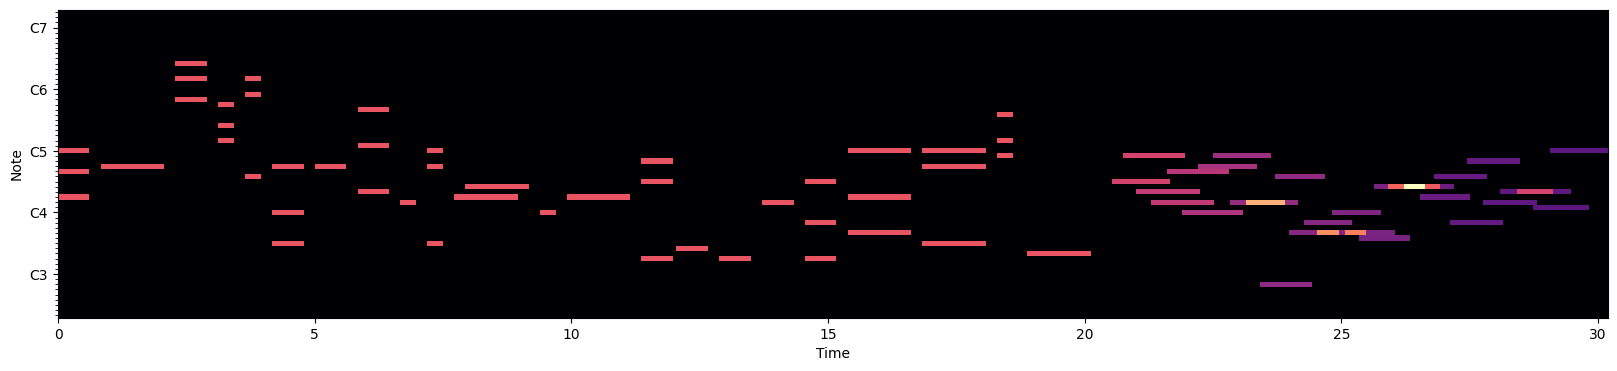

In [15]:
Utilities.plot_piano_roll(combined, 40, 100)

Visualizamos la imagen

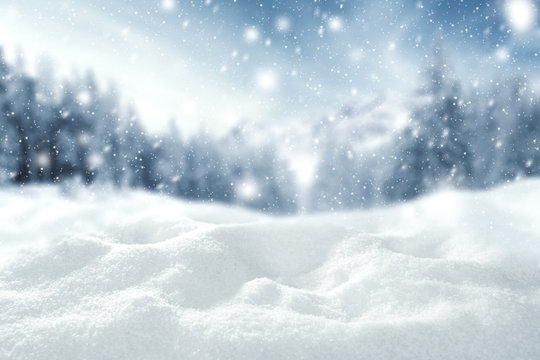

In [16]:
im.show()

Escuchamos el resultado

In [17]:
Utilities.display_audio(combined, seconds=60)

Por último lo guardamos

In [18]:
combined.write("midi_nieve.mid")

## Bucle para procesar varias imágenes seguidas

Este notebook es una demostración, pero se podrían procesas varias imágenes seguidas con un bucle. Por ejemplo, todas las imágenes que estan dentro de un determinado directorio.

In [ ]:
TEST_FOLDER = "models/foto_a_midi/datos/test"

for filename in os.listdir(TEST_FOLDER):
    if filename.lower().endswith((".png", ".jpg", ".jpeg")):
        image_path = os.path.join(TEST_FOLDER, filename)
        imagen = Image.open(image_path)
        params = modelo_params.predict(im)
        keys = params.keys()
        values = clip_parametros(list(params.values()))
        params2 = dict(zip(keys, values))

        MIDI_PATH = f"{filename}.mid"
        # Generamos el midi a partir de los parámetros obtenidos
        midi_basico = ParamsAMIDI(**params2)
        midi_basico.generar_midi(MIDI_PATH)
        # Si el midi tiene menos de 25 notas, lo concatenamos
        pm = pretty_midi.PrettyMIDI(MIDI_PATH)
        
        num_notas = len(pm.instruments[0].notes)

        if (num_notas < 25):
            n = 25 / num_notas + 1
            aux = pm
            for i in range(0, n):
                aux = Utilities.concatenate_pretty_midi(pm, aux)
            pm = aux

        df = Utilities.midi_path_to_df(MIDI_PATH)
        notes = Utilities.midi_to_numpy(pm)
        notes_sequence = notes[num_notas-25:num_notas] # últimas 25 notas
        notes = MelodIAModel.normalize(notes_sequence) 
        
        generated_notes = MelodIAModel.predict_sequence(modelo_extender_midi, notes, num_predictions=40, temperature=0.8)

        generated_notes = MelodIAModel.desnormalize(generated_notes)
        generado = Utilities.notes_to_midi(generated_notes)

        combined = Utilities.concatenate_pretty_midi(pm, generado)
        combined.write(f"{filename}_final.mid")